# Sklearn Pipeline

Implementation of pipelines in a scikit-learn machine learning workflow

# 1)-Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# For data processing and maths
import numpy as np
import pandas as pd
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline


In [5]:
# For data pipleline 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from custom_transformers import ColumnExtractor, DFStandardScaler, DFFeatureUnion, DFImputer
from custom_transformers import DummyTransformer, Log1pTransformer, ZeroFillTransformer
from custom_transformers import DateFormatter, DateDiffer, MultiEncoder

# 2)-Loading data

source: https://data.seattle.gov/Permitting/Special-Events-Permits/dm95-f8w5

In [6]:
df = pd.read_csv('Special_Events_Permits_2016.csv')

In [7]:
df.head()

,application_date,permit_status,permit_type,event_category,event_sub_category,name_of_event,year_month_app,event_start_date,event_end_date,event_location_park,event_location_neighborhood,council_district,precinct,organization,attendance
0,12/09/2015 12:00:00 AM,Complete,Special Event,Athletic,Run/Walk,See Jane Run Women's Half Marathon and 5K,S16JY044,07/10/2016 12:00:00 AM,07/10/2016 12:00:00 AM,Gas Works Park,Multiple Neighborhoods,3,North,See Jane Run,4500.0
1,01/07/2016 12:00:00 AM,Complete,Special Event,Commercial,NaN,Capitol Hill Block Party,S16JY046,07/22/2016 12:00:00 AM,07/24/2016 12:00:00 AM,NaN,Capitol Hill,3,East,Independent Event Solutions,27000.0
2,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.09),S16JY074,07/09/2016 12:00:00 AM,07/09/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
3,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.13),S16JY075,07/13/2016 12:00:00 AM,07/13/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
4,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.31),S16JY076,07/31/2016 12:00:00 AM,07/31/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0


"NaN" is not a string, rather it's a special value: numpy.nan

In [8]:
print(df.shape)

(529, 15)


In [9]:
df.columns

Index(['application_date', 'permit_status', 'permit_type', 'event_category',
       'event_sub_category', 'name_of_event', 'year_month_app',
       'event_start_date', 'event_end_date', 'event_location_park',
       'event_location_neighborhood', 'council_district', 'precinct',
       'organization', 'attendance'],
      dtype='object')

### Checking all variables with their data-type

In [10]:
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df)
table_dtype

,Data Type
attendance,float64
application_date,object
permit_status,object
permit_type,object
event_category,object
event_sub_category,object
name_of_event,object
year_month_app,object
event_start_date,object
event_end_date,object


### dependant variables

In [21]:
df['permit_status'].unique()

array(['Complete', 'Cancelled', 'In Process'], dtype=object)

In [19]:
df['permit_status'].value_counts()

Complete      476
Cancelled      38
In Process     15
Name: permit_status, dtype: int64

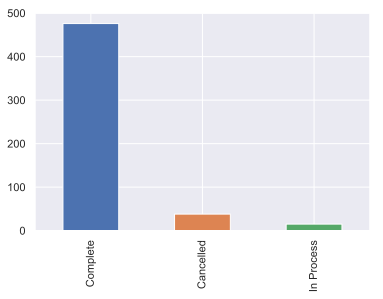

In [22]:
df['permit_status'].value_counts().plot(kind='bar')

### Checking missing values

In [12]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [13]:
missing_values = find_missing_values(df, columns=df.columns)
missing_values

Number of missing or NaN values for each column:


{'application_date': 4,
 'permit_status': 0,
 'permit_type': 0,
 'event_category': 101,
 'event_sub_category': 450,
 'name_of_event': 0,
 'year_month_app': 0,
 'event_start_date': 0,
 'event_end_date': 0,
 'event_location_park': 487,
 'event_location_neighborhood': 0,
 'council_district': 0,
 'precinct': 0,
 'organization': 2,
 'attendance': 3}

We shall data pipeline to do all preprocessing and later we shall use ML model with pipeline as well

### separating dataset into train and test

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.25, random_state=2019)

In [15]:
print(df_train.shape)
print(df_test.shape)

(396, 15)
(133, 15)


In [16]:
df_train.head()

,application_date,permit_status,permit_type,event_category,event_sub_category,name_of_event,year_month_app,event_start_date,event_end_date,event_location_park,event_location_neighborhood,council_district,precinct,organization,attendance
51,03/21/2016 12:00:00 AM,Complete,Special Event,Free Speech,NaN,Protest anti Barnevernet CPA in Norway,S16AP198,04/16/2016 12:00:00 AM,04/16/2016 12:00:00 AM,NaN,Downtown,7,West,First Romanian Pentecostal Church,950.0
235,05/24/2016 12:00:00 AM,In Process,Special Event,Citywide,NaN,Seafair Weekend,S16AU305,08/05/2016 12:00:00 AM,08/07/2016 12:00:00 AM,NaN,Mount Baker,1;2;3;4;5;6;7,East;North;South;West,Seafair,175300.0
26,12/15/2015 12:00:00 AM,Complete,Special Event,Athletic,Cycling,Emerald City Bicycle Ride,S16AP025,04/03/2016 12:00:00 AM,04/03/2016 12:00:00 AM,NaN,University District,2;3,North,Cascade Bicycle Club,6300.0
395,06/07/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Bite of Broadview,S16SE339,09/23/2016 12:00:00 AM,09/25/2016 12:00:00 AM,NaN,Broadview,5,North,Christ the King Catholic Church,2090.0
197,02/10/2016 12:00:00 AM,Complete,Special Event,Commercial,NaN,Sonia & Kiran Wedding Procession,S16MY120,05/21/2016 12:00:00 AM,05/21/2016 12:00:00 AM,NaN,Downtown,7,West,Sarika Paul,70.0


# 3)- Baseline Model

In [17]:
# Binary outcome as "permit_status" being our dependant variable
y_train = np.where(df_train.permit_status == 'Complete', 1, 0)
y_test = np.where(df_test.permit_status == 'Complete', 1, 0)

In [18]:
# Single feature
X_train_1 = df_train[['attendance']].fillna(value=0)
X_test_1 = df_test[['attendance']].fillna(value=0)

### Fit model

In [23]:
model_1 = LogisticRegression(random_state=5678)
model_1.fit(X_train_1, y_train)
y_pred_train_1 = model_1.predict(X_train_1)
p_pred_train_1 = model_1.predict_proba(X_train_1)[:, 1]

In [24]:
y_pred_train_1[:5]

array([1, 0, 1, 1, 1])

In [25]:
p_pred_train_1[:5]

array([0.9018508 , 0.05857135, 0.88742289, 0.8989216 , 0.90405995])

### Evaluate model

In [26]:
# checking null score
p_baseline_test = [y_train.mean()]*len(y_test)
auc_baseline = roc_auc_score(y_test, p_baseline_test)
print(auc_baseline)

0.5


In [27]:
# checking base model score
y_pred_test_1 = model_1.predict(X_test_1)
p_pred_test_1 = model_1.predict_proba(X_test_1)[:, 1]
auc_test_1 = roc_auc_score(y_test, p_pred_test_1)
print(auc_test_1) 

0.4020325203252033


# 4)- Data PIPELINE

### 4.1)-# Group columns by type of preprocessing needed

In [28]:
OUTCOME = 'permit_status'
NEAR_UNIQUE_FEATS = ['name_of_event', 'year_month_app', 'organization']
CAT_FEATS = [
    'permit_type', 'event_category', 'event_sub_category',
    'event_location_park', 'event_location_neighborhood']
MULTI_FEATS = ['council_district', 'precinct']
DATE_FEATS = ['application_date', 'event_start_date', 'event_end_date']
NUM_FEATS = ['attendance']

### 4.2)-# Preprocessing with a Pipeline

In [29]:
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer()),
            ('log', Log1pTransformer())
        ]))
    ])),
    ('scale', DFStandardScaler())
])
pipeline.fit(df_train)
X_train_2 = pipeline.transform(df_train)
X_test_2 = pipeline.transform(df_test)

### Fit model

In [30]:
model_2 = LogisticRegression(random_state=2019)
model_2.fit(X_train_2, y_train)
y_pred_train_2 = model_2.predict(X_train_2)
p_pred_train_2 = model_2.predict_proba(X_train_2)[:, 1]

### Evaluate model

In [31]:
p_pred_test_2 = model_2.predict_proba(X_test_2)[:, 1]
auc_test_2 = roc_auc_score(y_test, p_pred_test_2)
print(auc_test_2)  # 0.705084745763

0.743089430894309


# 5)- Data Pipeline with more features

### 5.1)- Preprocessing with a Pipeline

In [32]:
pipeline3 = Pipeline([
    ('features', DFFeatureUnion([
        ('dates', Pipeline([
            ('extract', ColumnExtractor(DATE_FEATS)),
            ('to_date', DateFormatter()),
            ('diffs', DateDiffer()),
            ('mid_fill', DFImputer(strategy='median'))
        ])),
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('multi_labels', Pipeline([
            ('extract', ColumnExtractor(MULTI_FEATS)),
            ('multi_dummy', MultiEncoder(sep=';'))
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer()),
            ('log', Log1pTransformer())
        ]))
    ])),
    ('scale', DFStandardScaler())
])
pipeline3.fit(df_train)
X_train_3 = pipeline3.transform(df_train)
X_test_3 = pipeline3.transform(df_test)

C:\Users\69785hsh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### 5.2)-Fit model

In [33]:
model_3 = LogisticRegression(random_state=5678)
model_3.fit(X_train_3, y_train)
y_pred_train_3 = model_3.predict(X_train_3)
p_pred_train_3 = model_3.predict_proba(X_train_3)[:, 1]

### 5.3)- Evaluate model

In [34]:
p_pred_test_3 = model_3.predict_proba(X_test_3)[:, 1]
auc_test_3 = roc_auc_score(y_test, p_pred_test_3)
print(auc_test_3)

0.6617886178861788


In [ ]:
With too many features, starting to overfit